In [0]:
# importing libraries

import os
import torch
import pickle
import imageio
import itertools
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import torch.nn.functional as F
from torchvision import datasets
from torch.autograd import Variable
from torch.utils.data import DataLoader
from time import time, gmtime, strftime
from torchvision.transforms import Compose, ToTensor, Normalize, Resize

In [0]:
# generator and discriminator classes

class Discriminator(nn.Module):
    def __init__(self, ip=1, hidden=128, op=1):
        super(Discriminator, self).__init__()
        self.conv1 = nn.Conv2d(ip, hidden, 4, 2, 1)
        self.conv2 = nn.Conv2d(hidden, hidden * 2, 4, 2, 1)
        self.conv3 = nn.Conv2d(hidden * 2, hidden * 4, 4, 2, 1)
        self.conv4 = nn.Conv2d(hidden * 4, hidden * 8, 4, 2, 1)
        self.conv5 = nn.Conv2d(hidden * 8, op, 4, 1, 0)
        self.bn1 = nn.BatchNorm2d(hidden)
        self.bn2 = nn.BatchNorm2d(hidden * 2)
        self.bn3 = nn.BatchNorm2d(hidden * 4)
        self.bn4 = nn.BatchNorm2d(hidden * 8)

    def forward(self, x):
        x = self.conv1(x)
        x = F.leaky_relu(x, 0.2)
        x = self.conv2(x)
        x = self.bn2(x)
        x = F.leaky_relu(x, 0.2)
        x = self.conv3(x)
        x = self.bn3(x)
        x = F.leaky_relu(x, 0.2)
        x = self.conv4(x)
        x = self.bn4(x)
        x = F.leaky_relu(x, 0.2)
        x = self.conv5(x)
        x = torch.sigmoid(x)
        return x


class Generator(nn.Module):
    def __init__(self, ip=100, hidden=128, op=1):
        super(Generator, self).__init__()
        self.deconv1 = nn.ConvTranspose2d(ip, hidden * 8, 4, 1, 0)
        self.deconv2 = nn.ConvTranspose2d(hidden * 8, hidden * 4, 4, 2, 1)
        self.deconv3 = nn.ConvTranspose2d(hidden * 4, hidden * 2, 4, 2, 1)
        self.deconv4 = nn.ConvTranspose2d(hidden * 2, hidden, 4, 2, 1)
        self.deconv5 = nn.ConvTranspose2d(hidden, op, 4, 2, 1)
        self.bn1 = nn.BatchNorm2d(hidden * 8)
        self.bn2 = nn.BatchNorm2d(hidden * 4)
        self.bn3 = nn.BatchNorm2d(hidden * 2)
        self.bn4 = nn.BatchNorm2d(hidden)

    def forward(self, x):
        x = self.deconv1(x)
        x = self.bn1(x)
        x = F.relu(x)
        x = self.deconv2(x)
        x = self.bn2(x)
        x = F.relu(x)
        x = self.deconv3(x)
        x = self.bn3(x)
        x = F.relu(x)
        x = self.deconv4(x)
        x = self.bn4(x)
        x = F.relu(x)
        x = self.deconv5(x)
        x = torch.tanh(x)
        return x

In [0]:
# utility functions

'''
> some utility functions to carry out post processing.
> save results() saves resulting images after each epoch.
> save checkpoint() saves generator and discriminator model after training ends. 
> create_gif() creates a gif of the save_results() images.
> plot() creates the loss plot.
'''

def save_results(epoch, gen=None, show=False, save=False, path='result/output/output_{}.png', device='cuda'):
    if not os.path.exists('result/output'):
        os.makedirs('result/output')

    fixed_noise = Variable(torch.randn((5 * 5, 100)).view(-1, 100, 1, 1).to(device))

    gen.eval()
    test_images = gen(fixed_noise)
    gen.train()

    size_figure_grid = 5
    fig, ax = plt.subplots(size_figure_grid, size_figure_grid, figsize=(5, 5))
    for i, j in itertools.product(range(size_figure_grid), range(size_figure_grid)):
        ax[i, j].get_xaxis().set_visible(False)
        ax[i, j].get_yaxis().set_visible(False)

    for k in range(5 * 5):
        i = k // 5
        j = k % 5
        ax[i, j].cla()
        ax[i, j].imshow(test_images[k, 0].cpu().data.numpy(), cmap='gray')

    label = 'Epoch {0}'.format(epoch)
    fig.text(0.5, 0.04, label, ha='center')

    if save:
        plt.savefig(path.format(epoch))
    if show:
        plt.show()
    else:
        plt.close()


def save_checkpoint(gen=None, disc=None):
    if not os.path.exists('model'):
        os.makedirs('model')
    torch.save(gen, "model/gen.pt")
    torch.save(disc, "model/disc.pt")


def create_gif(path='result/output'):
    images = []
    for files in os.listdir(path):
        images.append(imageio.imread(os.path.join(path, files)))
    imageio.mimsave('result/progress.gif', images, fps=5)


def plot(show=False, save=False, path='result/loss_plot.png'):
    if not os.path.exists('result/losses.pkl'):
        print('Loss pickle not found')
    else:
        with open('result/losses.pkl', 'rb') as f:
            losses = pickle.load(f)

        if not os.path.exists('result'):
            os.makedirs('result')

        x = range(len(losses['disc_loss']))
        y1 = losses['gen_loss']
        y2 = losses['disc_loss']
        plt.plot(x, y1, label='gen_loss')
        plt.plot(x, y2, label='disc_loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend(loc=4)
        plt.grid(True)
        plt.tight_layout()
        if save:
            plt.savefig(path)
        if show:
            plt.show()
        else:
            plt.close()

In [0]:
# load the train and test data

'''
> this particular notebook works with MNIST dataset.
> so this function downloads and loads the dataset for training.
'''

def load_data(batch_size=32, size=64):
    download = True
    if os.path.exists('data/MNIST_data/'):
        print('Dataset found, skipping download')
        download = False
    else:
        print('Dataset not found, downloading')

    train_data = datasets.MNIST(root='data/MNIST_data/',
                                transform=Compose([Resize(size),
                                                   ToTensor(),
                                                   Normalize(mean=[0.5], std=[0.5])
                                                   ]),
                                train=True,
                                download=download)

    test_data = datasets.MNIST(root='data/MNIST_data/',
                               transform=Compose([Resize(size),
                                                  ToTensor(),
                                                  Normalize(mean=[0.5], std=[0.5])
                                                  ]),
                               train=False,
                               download=download)

    train_loader = DataLoader(train_data,
                              batch_size=batch_size,
                              shuffle=True)

    test_loader = DataLoader(test_data,
                             batch_size=batch_size,
                             shuffle=False)

    return train_loader, test_loader

In [0]:
# training function for generator and discriminator

def train_gen(gen, disc, optimizer, criterion, x, device):
    gen.zero_grad()

    mini_batch = x.size()[0]
    z = Variable(torch.randn((mini_batch, 100)).view(-1, 100, 1, 1).to(device))
    y = Variable(torch.ones(mini_batch).to(device))

    # forward pass
    gen_op = gen(z)
    disc_op = disc(gen_op).squeeze()
    gen_loss = criterion(disc_op, y)

    # backward pass optimizing only gen's param
    gen_loss.backward()
    optimizer.step()

    return gen_loss.item()


def train_disc(disc, gen, optimizer, criterion, x, device):
    disc.zero_grad()

    # training on real data
    mini_batch = x.size()[0]
    y_real = Variable(torch.ones(mini_batch).to(device))
    x = Variable(x.to(device))

    disc_op = disc(x).squeeze()
    disc_real_loss = criterion(disc_op, y_real)

    # training on fake data
    z = Variable(torch.randn(mini_batch, 100).view(-1, 100, 1, 1).to(device))
    gen_op = gen(z)
    y_fake = Variable(torch.zeros(mini_batch).to(device))

    disc_op = disc(gen_op).squeeze()
    disc_fake_loss = criterion(disc_op, y_fake)

    # backward pass optimizing only disc's param
    disc_loss = disc_real_loss + disc_fake_loss
    disc_loss.backward()
    optimizer.step()

    return disc_loss.item()

In [0]:
# wrapper training function for GAN

'''
> starts the training of generator and discrimator.
> saves the losses of both networks.
> losses used later to plot loss graph.
'''

def train_gan(gen, disc, gen_opt, disc_opt, criterion, device, epoch, train_loader):
    gen_loss = []
    disc_loss = []

    epoch_start = time()
    for img, label in train_loader:
        disc_loss.append(train_disc(disc, gen, disc_opt, criterion, img, device))
        gen_loss.append(train_gen(gen, disc, gen_opt, criterion, img, device))

    end = time() - epoch_start
    print('epoch = {} | disc_loss = {:.6f} | gen_loss = {:.6f} | time elapsed in epoch = {}'.format(epoch + 1,
                                                                                                   torch.mean(torch.FloatTensor(disc_loss)),
                                                                                                   torch.mean(torch.FloatTensor(gen_loss)),
                                                                                                   strftime("%H:%M:%S", gmtime(end))))
    return gen_loss, disc_loss

In [0]:
# hyperparameters

num_epochs = 20
batch_size = 32
lr = 0.0002
size = 64

Dataset not found, downloading


Extracting data/MNIST_data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST_data/MNIST/raw


Extracting data/MNIST_data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST_data/MNIST/raw



Extracting data/MNIST_data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST_data/MNIST/raw


Extracting data/MNIST_data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST_data/MNIST/raw
Processing...
Done!





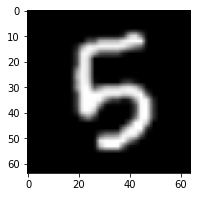

In [8]:
# obtain one batch of training images
import numpy as np

def get_batch(batch_size=32, size=64):
    train_loader, test_loader = load_data(batch_size=batch_size, size=size)
    dataiter = iter(train_loader)
    images, labels = dataiter.next()
    images = images.numpy()

    # get one image from the batch
    img = np.squeeze(images[0])

    fig = plt.figure(figsize = (3,3)) 
    ax = fig.add_subplot(111)
    ax.imshow(img, cmap='gray')

get_batch(batch_size=batch_size, size=size)

In [0]:
# main function

def main():
    torch.manual_seed(1)
    device = torch.device('cuda')
    total_loss = {'disc_loss': [], 'gen_loss': []}
    gen = Generator(ip=100, hidden=128, op=1).to(device)
    disc = Discriminator(ip=1, hidden=128, op=1).to(device)
    gen_opt = optim.Adam(gen.parameters(), lr=lr, betas=(0.5, 0.999))
    disc_opt = optim.Adam(disc.parameters(), lr=lr, betas=(0.5, 0.999))
    criterion = nn.BCELoss()
    train_loader, test_loader = load_data(batch_size=batch_size, size=size)

    print('Dataset loaded. Training starts now....')
    start = time()

    for epoch in range(num_epochs):
        gen_loss, disc_loss = train_gan(gen, disc, gen_opt, disc_opt, criterion, device, epoch, train_loader)
        total_loss['gen_loss'].append(torch.mean(torch.FloatTensor(gen_loss)))
        total_loss['disc_loss'].append(torch.mean(torch.FloatTensor(disc_loss)))

        save_results(epoch, gen=gen, show=False, save=True, path='result/output/output_{}.png', device='cuda')
    save_checkpoint(gen=gen, disc=disc)

    end = time() - start
    print('Training done | Time Elapsed --> {}'.format(strftime("%H:%M:%S", gmtime(end))))

    # saving losses
    with open('result/losses.pkl', 'wb') as f:
        pickle.dump(total_loss, f)

In [10]:
main()

Dataset found, skipping download
Dataset loaded. Training starts now....
epoch = 1 | disc_loss = 0.5220561027526855 | gen_loss = 5.84838342666626 | time elapsed in epoch = 00:07:19
epoch = 2 | disc_loss = 0.6221365928649902 | gen_loss = 3.48418927192688 | time elapsed in epoch = 00:07:27
epoch = 3 | disc_loss = 0.3654763102531433 | gen_loss = 5.746403217315674 | time elapsed in epoch = 00:07:27
epoch = 4 | disc_loss = 0.37725383043289185 | gen_loss = 4.326971054077148 | time elapsed in epoch = 00:07:28
epoch = 5 | disc_loss = 0.3092593848705292 | gen_loss = 4.615067005157471 | time elapsed in epoch = 00:07:28
epoch = 6 | disc_loss = 0.29780313372612 | gen_loss = 4.844455718994141 | time elapsed in epoch = 00:07:26
epoch = 7 | disc_loss = 0.23862451314926147 | gen_loss = 5.293932914733887 | time elapsed in epoch = 00:07:26
epoch = 8 | disc_loss = 0.2164933979511261 | gen_loss = 5.327288627624512 | time elapsed in epoch = 00:07:26
epoch = 9 | disc_loss = 0.18348772823810577 | gen_loss = 

/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type Generator. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type Discriminator. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


In [0]:
create_gif(path='result/output')  # create gif of output images

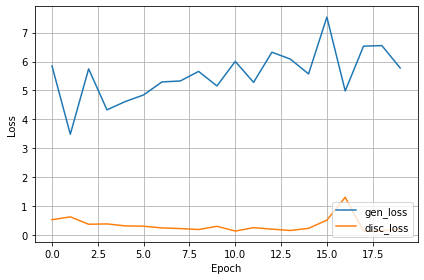

In [11]:
plot(show=True, save=True, path='result/loss_plot.png')

In [0]:
import shutil

zipf = zipfile.ZipFile('dowload.zip', 'w', zipfile.ZIP_DEFLATED)
for dirs in os.listdir('.'):
    if dirs == 'model' or dirs == 'result':
        shutil.make_archive(dirs, 'zip', dirs)